# Model Example 

This notebook contains example code to run the model and examine the outputs. 

In [1]:
# General Imports
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, StrMethodFormatter

# Repo Imports 
import models.dispatch_opt as disp_opt
import post_processing.finance_calcs as fin_calc


In [2]:
# Set styles
plt.style.use('seaborn-v0_8')
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rc('axes', labelsize=18)
matplotlib.rc('axes', titlesize=24)
matplotlib.rc('lines', linewidth=3)

In [14]:
# Load inputs
input_path = r'C:\Users\jpsta\code\energy-modeling\data\storage_model_inputs.xlsx'
input_ts = pd.read_excel(input_path, sheet_name='Time-Series Data', parse_dates=['INTERVAL_START'])
input_scalar = pd.read_excel(input_path, sheet_name='Scalar Parameters', skiprows=1)


# Select one row from the input scalar dataframe
row = input_scalar.iloc[[-2], :]

# Create and run model
m, _ = disp_opt.battery_model_lp(input_ts, row)

# Calculate financial data 
df_results, npv_battery, daily_finances = fin_calc.calculate_profit(m, input_ts, row)

Running HiGHS 1.12.0 (git hash: 755a8e0): Copyright (c) 2025 HiGHS under MIT licence terms
LP has 1177 rows; 672 cols; 2182 nonzeros
Coefficient ranges:
  Matrix  [2e-02, 6e+01]
  Cost    [1e+02, 3e+02]
  Bound   [0e+00, 0e+00]
  RHS     [1e-01, 2e+01]
Presolving model
333 rows, 500 cols, 998 nonzeros  0s
Dependent equations search running on 167 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
333 rows, 500 cols, 998 nonzeros  0s
Presolve reductions: rows 333(-844); columns 500(-172); nonzeros 998(-1184) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
        302     3.6669736630e+05 Pr: 0(0) 0s

Performed postsolve
Solving the original LP from the solution after postsolve

Model status        : Optimal
Simplex   iterations: 302
Objective value     :  3.6669736630e+05
P-D objective error :  1.

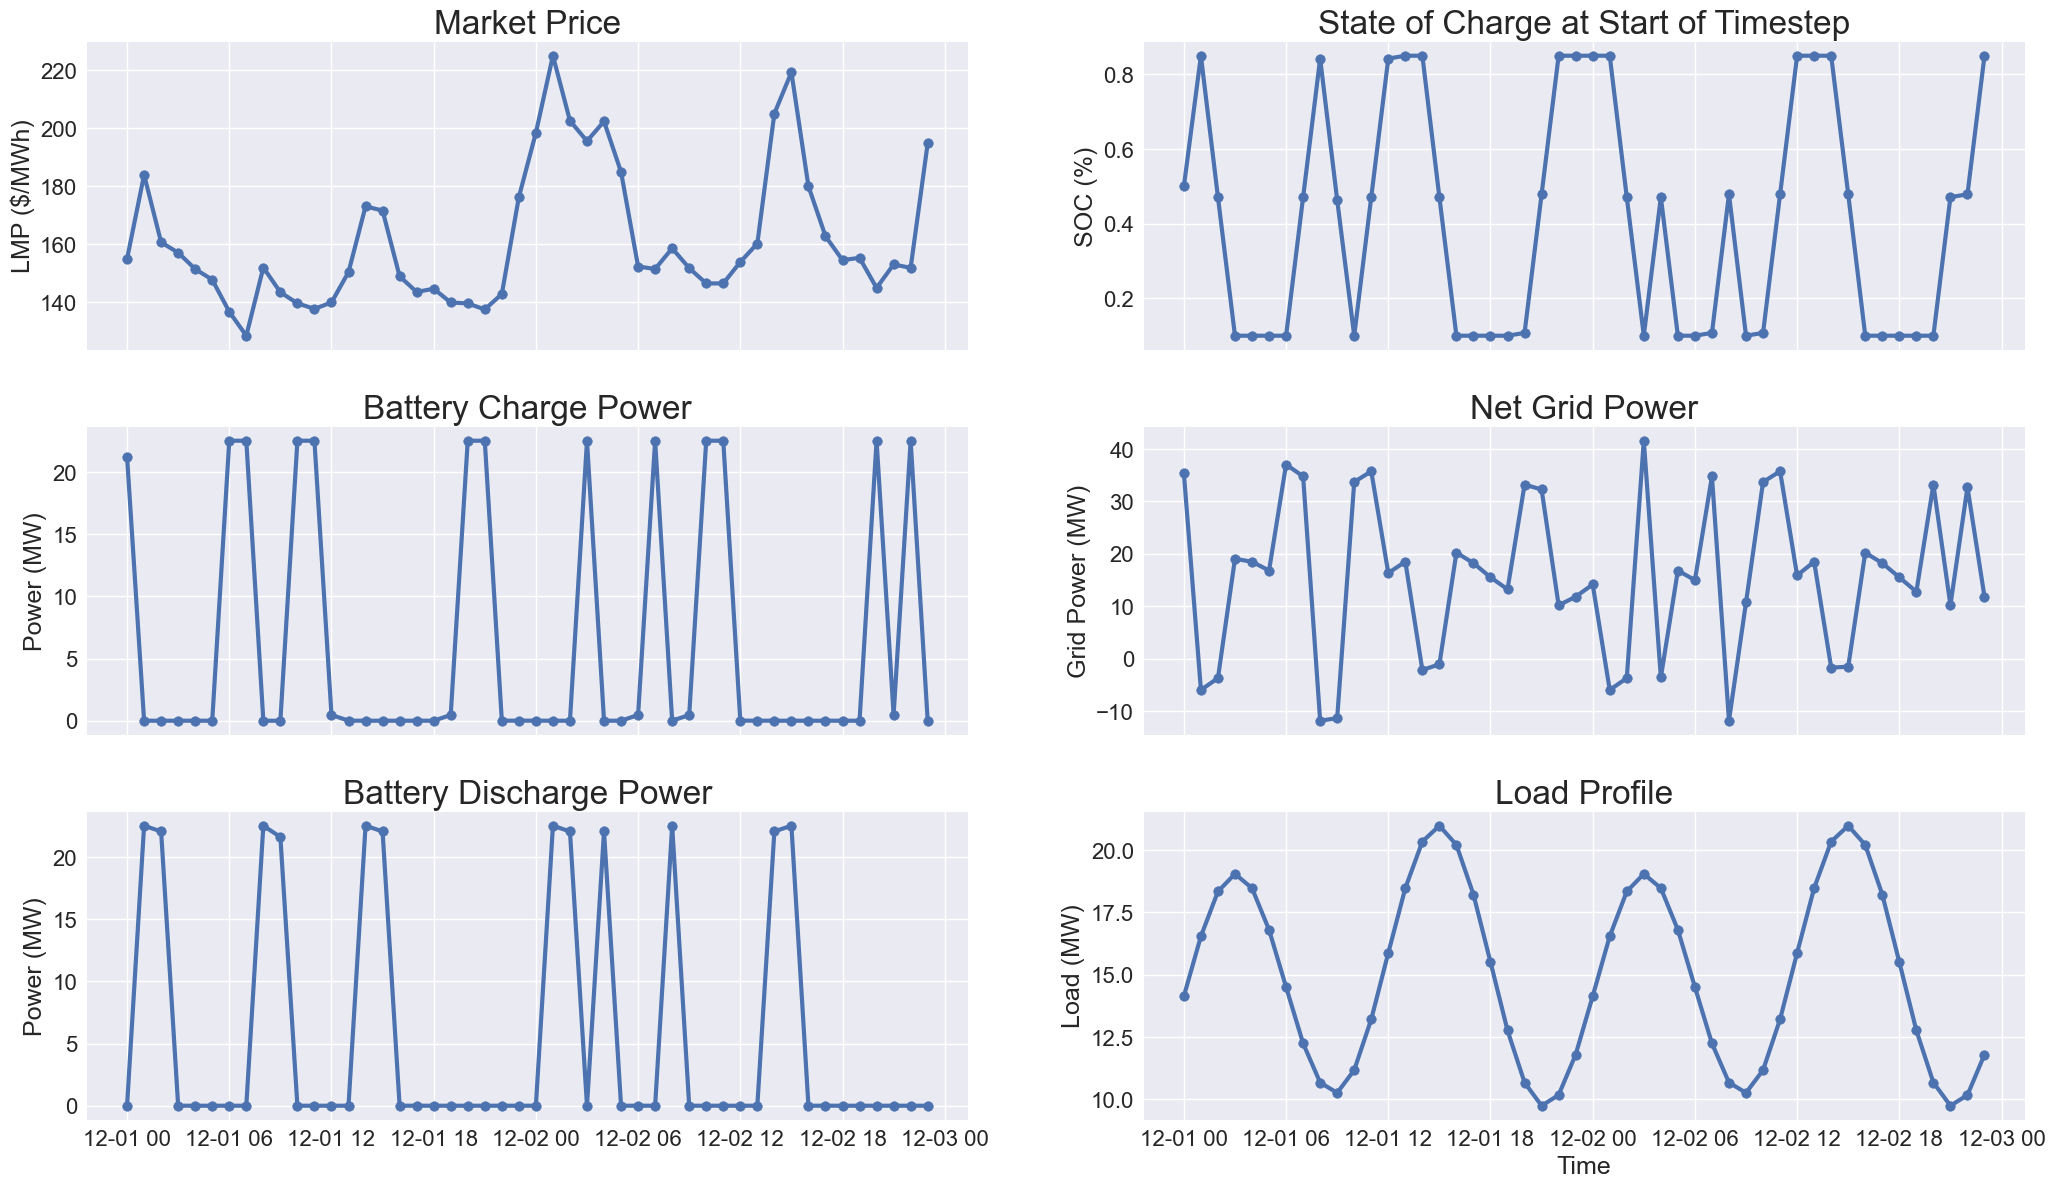

In [ ]:
# Sanity Checks 

df = df_results[df_results["time (hours)"].between("2022-12-01", "2022-12-02 23:59:59")]

# Ensure time column is datetime and sorted
df = df.sort_values("time (hours)")
df["time (hours)"] = pd.to_datetime(df["time (hours)"])

fig, axes = plt.subplots(
    nrows=3, ncols=2, figsize=(25, 14), sharex=True,
    gridspec_kw={"hspace": 0.25}
)

n = 0
# --- 1. Load ---
n=(0,0)
axes[n].plot(df["time (hours)"], df["LMP"])
axes[n].scatter(df["time (hours)"], df["LMP"])
axes[n].set_ylabel("LMP ($/MWh)")
axes[n].set_title("Market Price")


# --- 2. Charge & Discharge Power ---
n=(1,0)
axes[n].plot(df["time (hours)"], df["Charge Power (MW)"], label="Charge")
axes[n].scatter(df["time (hours)"], df["Charge Power (MW)"], label="Charge")
axes[n].set_ylabel("Power (MW)")
axes[n].set_title("Battery Charge Power")

n=(2,0)
axes[n].plot(df["time (hours)"], df["Discharge Power (MW)"], label="Discharge")
axes[n].scatter(df["time (hours)"], df["Discharge Power (MW)"], label="Discharge")
axes[n].set_ylabel("Power (MW)")
axes[n].set_title("Battery Discharge Power")

# --- 3. Grid Power ---
n=(0,1)
axes[n].plot(df["time (hours)"], df["SOC (%)"])
axes[n].scatter(df["time (hours)"], df["SOC (%)"])
axes[n].set_ylabel("SOC (%)")
axes[n].set_title("State of Charge at Start of Timestep")


# --- 4. SOC ---
n=(1,1)
axes[n].plot(df["time (hours)"], df["Grid Power (MW)"])
axes[n].scatter(df["time (hours)"], df["Grid Power (MW)"])
axes[n].set_ylabel("Grid Power (MW)")
axes[n].set_title("Net Grid Power")

# --- 5. Market Price ---
n = (2,1)
axes[n].plot(df["time (hours)"], df["load"])
axes[n].scatter(df["time (hours)"], df["load"])
axes[n].set_ylabel("Load (MW)")
axes[n].set_title("Load Profile")
axes[n].set_xlabel("Time")

plt.minorticks_on()

plt.show()


In [ ]:
# Tests

# Is the battery ever charging and discharging at the same time?
charging_and_discharging = df_results[(df_results["Charge Power (MW)"] > 0) & (df_results["Discharge Power (MW)"] > 0)]
if not charging_and_discharging.empty:
    print("Error Test 1: Battery is charging and discharging at the same time.")
else: 
    print("Pass Test 1: Battery is not charging and discharging at the same time.")


# Confirm SOC limits are respected
if (df_results["SOC (%)"] < row['Minimum SOC'].iloc[0]).any() or (df_results["SOC (%)"] > row['Maximum SOC'].iloc[0]).any():
    print("Error Test 2: SOC limits are violated.")
else:
    print("Pass Test 2: SOC limits are respected.")


# Confirm SOC matches expectations based on charge/discharge
tolerance = 1e-3  # Define a small tolerance for floating point comparisons
soc_violations = []
for i in range(1, len(df_results)):
    expected_soc = df_results["SOC (%)"].iloc[i-1] * (1 - row['Self-Discharge (%/hr)'].iloc[0] * row['Time Step (hours)'].iloc[0]) + \
        (row['Time Step (hours)'].iloc[0] / row['Capacity (MWh)'].iloc[0]) * \
        (df_results["Charge Power (MW)"].iloc[i-1] * row['One-Way Conversion Efficiency (%)'].iloc[0] - \
         df_results["Discharge Power (MW)"].iloc[i-1] / row['One-Way Conversion Efficiency (%)'].iloc[0])
    actual_soc = df_results["SOC (%)"].iloc[i]
    if abs(actual_soc - expected_soc) > tolerance:
        soc_violations.append((i, actual_soc, expected_soc))

if soc_violations:
    print("Error Test 3: SOC calculation violations found at the following timesteps:")
    for violation in soc_violations:
        print(f"  Timestep {violation[0]}: Actual SOC = {violation[1]}, Expected SOC = {violation[2]}")
else:
    print("Pass Test 3: SOC calculations are consistent with charge/discharge actions.")



Pass Test 1: Battery is not charging and discharging at the same time.
Pass Test 2: SOC limits are respected.
Pass Test 3: SOC calculations are consistent with charge/discharge actions.
